In [1]:
import string
import nltk
import numpy as numpy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem.porter import *
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.optimizers as keras_optimizers
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from google.colab import drive
drive.mount('/content/drive')

training_data = pd.read_csv('/content/drive/My Drive/Lab2/24_train_1.csv')
testing_data = pd.read_csv('/content/drive/My Drive/Lab2/news-test-1 - news-test.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive


In [2]:
def preprocess_text(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(no_punctuation)
    filtered_tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(filtered_tokens)

training_data['Processed_Text'] = training_data['Text'].apply(preprocess_text)
testing_data['Processed_Text'] = testing_data['Text'].apply(preprocess_text)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(training_data['Category'])

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
def evaluate_model(X, y):
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=500, random_state=42)
        model.fit(X_train, y_train)

        train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
        val_accuracies.append(accuracy_score(y_val, model.predict(X_val)))

    return {
        "train_accuracy_mean": numpy.mean(train_accuracies),
        "train_accuracy_std": numpy.std(train_accuracies),
        "val_accuracy_mean": numpy.mean(val_accuracies),
        "val_accuracy_std": numpy.std(val_accuracies),
    }

In [4]:
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(training_data['Processed_Text']).toarray()
count_results = evaluate_model(X_count, y)
print(count_results)

{'train_accuracy_mean': 1.0, 'train_accuracy_std': 0.0, 'val_accuracy_mean': 0.9709999999999999, 'val_accuracy_std': 0.009695359714832666}


In [5]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(training_data['Processed_Text']).toarray()
tfidf_results = evaluate_model(X_tfidf, y)
print(tfidf_results)

{'train_accuracy_mean': 1.0, 'train_accuracy_std': 0.0, 'val_accuracy_mean': 0.968, 'val_accuracy_std': 0.011661903789690611}


In [6]:
glove_path = "/content/drive/My Drive/Lab2/glove.6B.100d.txt"
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

def get_glove_embedding(text, glove_model, dim=100):
    tokens = text.split()
    embeddings = [glove_model[word] for word in tokens if word in glove_model]
    if embeddings:
        return numpy.mean(embeddings, axis=0)
    else:
        return numpy.zeros(dim)

X_glove = numpy.array([get_glove_embedding(doc, glove_model) for doc in training_data['Processed_Text']])
glove_results = evaluate_model(X_glove, y)
print(glove_results)

{'train_accuracy_mean': 1.0, 'train_accuracy_std': 0.0, 'val_accuracy_mean': 0.969, 'val_accuracy_std': 0.008602325267042634}


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

X_bert = numpy.vstack([get_bert_embedding(doc) for doc in training_data['Processed_Text']])
bert_results = evaluate_model(X_bert, y)
print(bert_results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

{'train_accuracy_mean': 1.0, 'train_accuracy_std': 0.0, 'val_accuracy_mean': 0.974, 'val_accuracy_std': 0.008602325267042634}


In [8]:
results_df = pd.DataFrame({
    "Feature method": ["CountVectorizer", "TF-IDF", "GloVe", "BERT"],
    "Training Accuracy Mean": [
        count_results["train_accuracy_mean"],
        tfidf_results["train_accuracy_mean"],
        glove_results["train_accuracy_mean"],
        bert_results["train_accuracy_mean"]
    ],
    "Training Accuracy Std": [
        count_results["train_accuracy_std"],
        tfidf_results["train_accuracy_std"],
        glove_results["train_accuracy_std"],
        bert_results["train_accuracy_std"]
    ],
    "Validation Accuracy Mean": [
        count_results["val_accuracy_mean"],
        tfidf_results["val_accuracy_mean"],
        glove_results["val_accuracy_mean"],
        bert_results["val_accuracy_mean"]
    ],
    "Validation Accuracy Std": [
        count_results["val_accuracy_std"],
        tfidf_results["val_accuracy_std"],
        glove_results["val_accuracy_std"],
        bert_results["val_accuracy_std"]
    ]
})

results = pd.DataFrame(results_df)
print("Feature Extraction Performance Results:")
print(results)

Feature Extraction Performance Results:
    Feature method  Training Accuracy Mean  Training Accuracy Std  \
0  CountVectorizer                     1.0                    0.0   
1           TF-IDF                     1.0                    0.0   
2            GloVe                     1.0                    0.0   
3             BERT                     1.0                    0.0   

   Validation Accuracy Mean  Validation Accuracy Std  
0                     0.971                 0.009695  
1                     0.968                 0.011662  
2                     0.969                 0.008602  
3                     0.974                 0.008602  


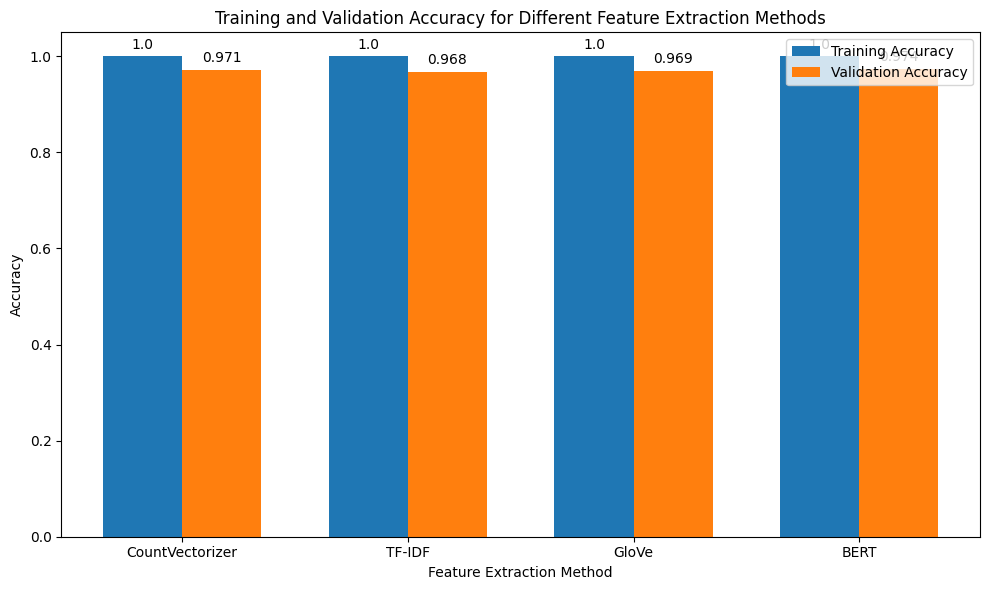

In [9]:
methods = results_df["Feature method"]
train_means = results_df["Training Accuracy Mean"]
train_stds = results_df["Training Accuracy Std"]
val_means = results_df["Validation Accuracy Mean"]
val_stds = results_df["Validation Accuracy Std"]
bar_width = 0.35
index = numpy.arange(len(methods))

fig, ax = plt.subplots(figsize=(10, 6))
train_bars = ax.bar(index, train_means, bar_width, label='Training Accuracy', capsize=5)

val_bars = ax.bar(index + bar_width, val_means, bar_width, label='Validation Accuracy', capsize=5)

ax.set_xlabel('Feature Extraction Method')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy for Different Feature Extraction Methods')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(methods)
ax.legend()

for bar in train_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

for bar in val_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [10]:
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
X_best = X_bert
train_means = []
train_stds = []
val_means = []
val_stds = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for lr in learning_rates:
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in kf.split(X_best):
        X_train, X_val = X_best[train_index], X_best[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = MLPClassifier(hidden_layer_sizes=(128, 128), learning_rate_init=lr, max_iter=100, random_state=42)
        model.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
        val_accuracies.append(accuracy_score(y_val, model.predict(X_val)))

    train_means.append(numpy.mean(train_accuracies))
    train_stds.append(numpy.std(train_accuracies))
    val_means.append(numpy.mean(val_accuracies))
    val_stds.append(numpy.std(val_accuracies))

results_df = pd.DataFrame({
    "Learning Rate": learning_rates,
    "Training Accuracy Mean": train_means,
    "Training Accuracy Std": train_stds,
    "Validation Accuracy Mean": val_means,
    "Validation Accuracy Std": val_stds
})
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

   Learning Rate  Training Accuracy Mean  Training Accuracy Std  \
0         0.0001                  0.9935               0.001458   
1         0.0003                  1.0000               0.000000   
2         0.0010                  1.0000               0.000000   
3         0.0030                  1.0000               0.000000   
4         0.0100                  1.0000               0.000000   
5         0.0300                  1.0000               0.000000   
6         0.1000                  0.5585               0.321239   

   Validation Accuracy Mean  Validation Accuracy Std  
0                     0.978                 0.011662  
1                     0.976                 0.006633  
2                     0.974                 0.008602  
3                     0.971                 0.008000  
4                     0.971                 0.008602  
5                     0.970                 0.010000  
6                     0.527                 0.295611  


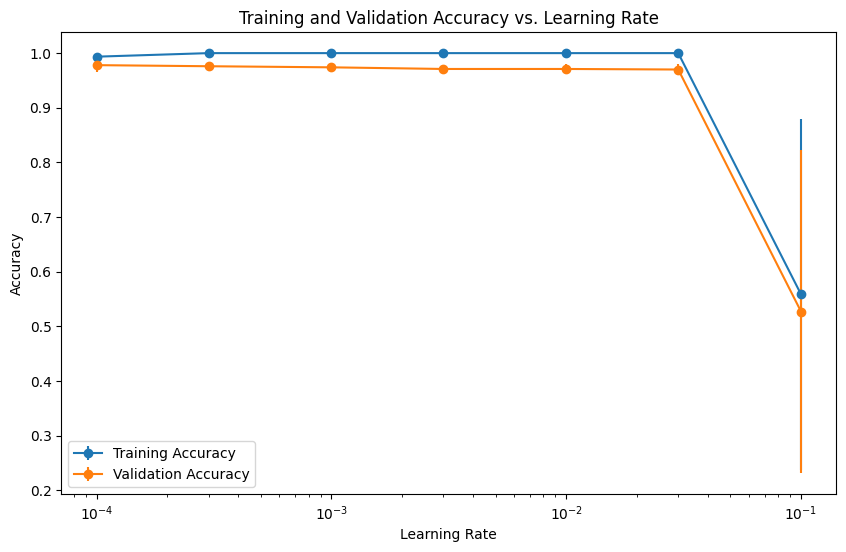

In [11]:
plt.figure(figsize=(10, 6))
plt.errorbar(learning_rates, train_means, yerr=train_stds, label='Training Accuracy', fmt='-o')
plt.errorbar(learning_rates, val_means, yerr=val_stds, label='Validation Accuracy', fmt='-o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Learning Rate')
plt.legend()
plt.show()

In [12]:
X_tensor = torch.tensor(X_best, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

def create_model(input_size, output_size=5):
    model = nn.Sequential(nn.Linear(input_size, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(),nn.Linear(128, output_size))
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

optimizers = ['SGD', 'Adam', 'RMSprop']
results = {
    "Optimizer": [],
    "Training Accuracy Mean": [],
    "Training Accuracy Std": [],
    "Validation Accuracy Mean": [],
    "Validation Accuracy Std": []
}

def evaluate_optimizer(optimizer_name):
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in kf.split(X_tensor):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
        model = create_model(X_best.shape[1], len(set(y)))
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        model.train()
        for epoch in range(10):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        model.eval()
        with torch.no_grad():
            train_correct = (model(X_train).argmax(1) == y_train).sum().item()
            train_accuracies.append(train_correct / len(y_train))

            val_correct = (model(X_val).argmax(1) == y_val).sum().item()
            val_accuracies.append(val_correct / len(y_val))

    results["Optimizer"].append(optimizer_name)
    results["Training Accuracy Mean"].append(numpy.mean(train_accuracies))
    results["Training Accuracy Std"].append(numpy.std(train_accuracies))
    results["Validation Accuracy Mean"].append(numpy.mean(val_accuracies))
    results["Validation Accuracy Std"].append(numpy.std(val_accuracies))

for opt in optimizers:
    evaluate_optimizer(opt)
results_df = pd.DataFrame(results)
print("Optimizer Performance Results:")
print(results_df)

Optimizer Performance Results:
  Optimizer  Training Accuracy Mean  Training Accuracy Std  \
0       SGD                 0.40725               0.073320   
1      Adam                 0.99850               0.001458   
2   RMSprop                 0.99575               0.002574   

   Validation Accuracy Mean  Validation Accuracy Std  
0                     0.398                 0.089699  
1                     0.977                 0.007483  
2                     0.973                 0.005099  


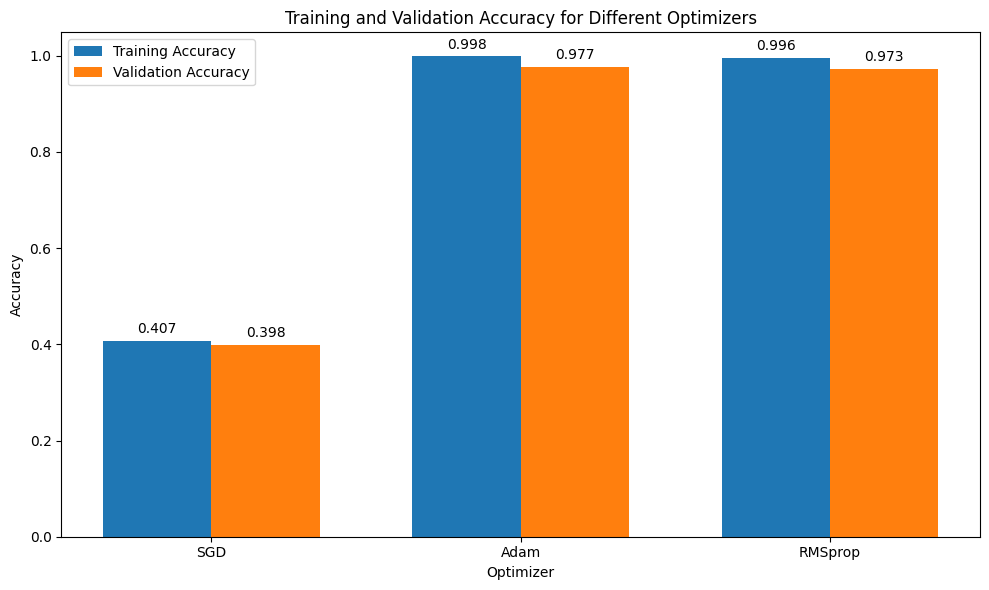

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
index = numpy.arange(len(optimizers))
bar_width = 0.35

train_means = results_df["Training Accuracy Mean"]
train_stds = results_df["Training Accuracy Std"]
val_means = results_df["Validation Accuracy Mean"]
val_stds = results_df["Validation Accuracy Std"]

train_bars = ax.bar(index, train_means, bar_width, label='Training Accuracy', capsize=5)
val_bars = ax.bar(index + bar_width, val_means, bar_width, label='Validation Accuracy', capsize=5)

ax.set_xlabel('Optimizer')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy for Different Optimizers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(optimizers)
ax.legend()

for bar in train_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

for bar in val_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [14]:
NN = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=500, solver='adam',learning_rate_init=0.0010, random_state=42)
results = cross_validate(NN, X_best, y, cv=5, return_train_score=True)
print(f"train set accuracy: {numpy.mean(results['train_score'])}")
print(f"validation set accuracy: {numpy.mean(results['test_score'])}")

train set accuracy: 1.0
validation set accuracy: 0.9789999999999999


In [15]:
X_bert_test = numpy.vstack([get_bert_embedding(doc) for doc in testing_data['Processed_Text']])
NN.fit(X_best, y)
test_pred = NN.predict(X_bert_test)

In [16]:
test_labels = label_encoder.inverse_transform(test_pred)
import csv
output_path = '/content/drive/My Drive/Lab2/labels.csv'
with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for article_id, label in zip(testing_data['ArticleId'], test_labels):
        writer.writerow([f"{article_id},{label}"])